In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import urllib
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

IDEIA: usar regressao logistica para resolver o problema, classificando as palavras que mais estao relacionadas com reviews negativas, e depois podemos usar um tfidf para achar as reviews mais negativas??

DATASET a ser ultilizado: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce 

In [ ]:
#TODO - tratar bonitinho para a regressao -> separar o csv de reviews, e pegar apenas as reviews que tem notas negativas (<= 3) E que tem comentario. 
#TODO - fazer train test split, aplicar a regressao

In [22]:
dataset = "datasets/olist_order_reviews_dataset.csv"
df = pd.read_csv(dataset)
print(df.shape)
df.head()

(99224, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [41]:
# drop rows with NaN values in review_comment_title and review_comment_message columns
df.dropna(subset=['review_comment_title', 'review_comment_message'], inplace=True)

# filter the dataset to include only reviews with a score that is equal or lower than 3
filtered_df = df[df['review_score'] <= 5]

# select only the desired columns
filtered_df = filtered_df.loc[:, ['review_score', 'review_comment_title', 'review_comment_message']]

# print the filtered dataset
print(filtered_df.shape)
filtered_df.head()

(9839, 3)


,review_score,review_comment_title,review_comment_message
9,4,recomendo,aparelho eficiente. no site a marca do aparelh...
15,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes..."
19,1,Não chegou meu produto,Péssimo
22,5,Ótimo,Loja nota 10
34,4,Muito bom.,Recebi exatamente o que esperava. As demais en...


In [42]:
# split the dataset into training and test sets
df_train, df_test = train_test_split(filtered_df, test_size=0.2, random_state=42)

# print the shapes of the training and test sets
print('Training set shape:', df_train.shape)
print('Test set shape:', df_test.shape)
df_train.head()

Training set shape: (7871, 3)
Test set shape: (1968, 3)


,review_score,review_comment_title,review_comment_message
72544,1,Mais o menos,Achei fraco
83800,3,Nome incompleto,"Recebi no prazo e tudo ok, porém não constava ..."
12535,4,Relogio casio,"O produro chegou dentro do prazo, é bem leve e..."
11861,4,Tudo como combinado,Nota 10
70890,5,Recomendo,Chegou bem antes


In [43]:
X_train = df_train['review_comment_message']
y_train = df_train['review_score']

X_test = df_test['review_comment_message']
y_test = df_test['review_score']

classificador = Pipeline([
                        ('meu_vetorizador', CountVectorizer()),
                        ('meu_classificador', LogisticRegression(penalty=None, solver='saga', max_iter=10000))
                        ])
classificador.fit(X_train,y_train)
y_pred = classificador.predict(X_test)
acc = accuracy_score(y_pred,y_test)
print(acc)

0.625


Palavras relacionadas a reviws de score 1:

(5, 6576)


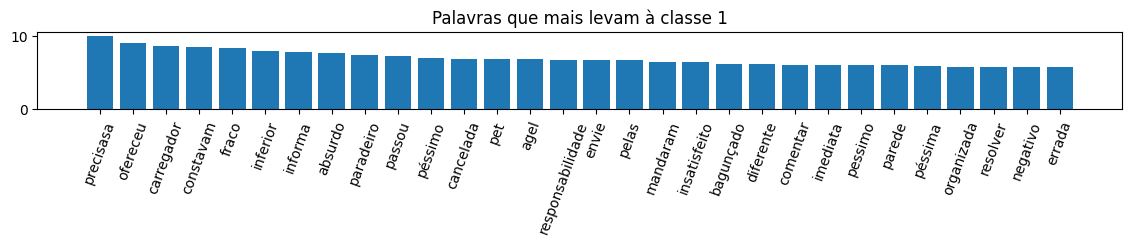

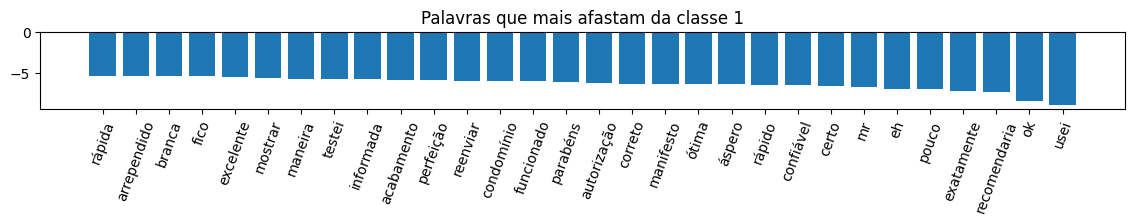

In [55]:
vocabulario = classificador['meu_vetorizador'].vocabulary_
pesos = classificador['meu_classificador'].coef_
print(pesos.shape)

classe_alvo = 0
classe_alvo_str = classificador.classes_[classe_alvo]

palavras_e_pesos = []
for palavra in vocabulario.keys():
    j = vocabulario[palavra]
    coeficiente = pesos[classe_alvo,j]
    palavras_e_pesos.append( (coeficiente, palavra) )

tuplas_ordenadas = sorted(palavras_e_pesos, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 30
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,1))
plt.title('Palavras que mais levam à classe ' + str(classe_alvo_str))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=70)
plt.show()

eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,1))
plt.title('Palavras que mais afastam da classe ' + str(classe_alvo_str))
plt.bar(eixo_x[-n_palavras:], contagens[-n_palavras:])
plt.xticks(eixo_x[-n_palavras:], palavras[-n_palavras:], rotation=70)
plt.show()

Palavras relacionadas a reviws de score 2:

(5, 6576)


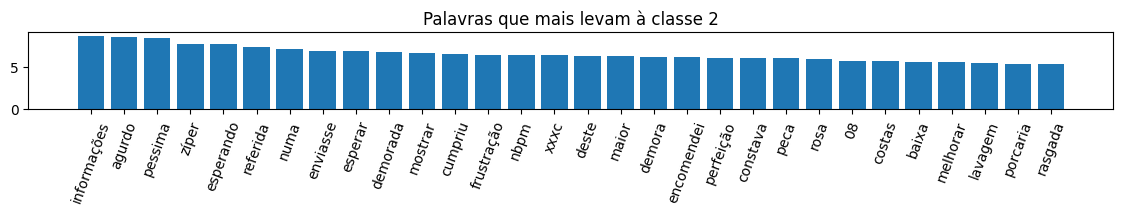

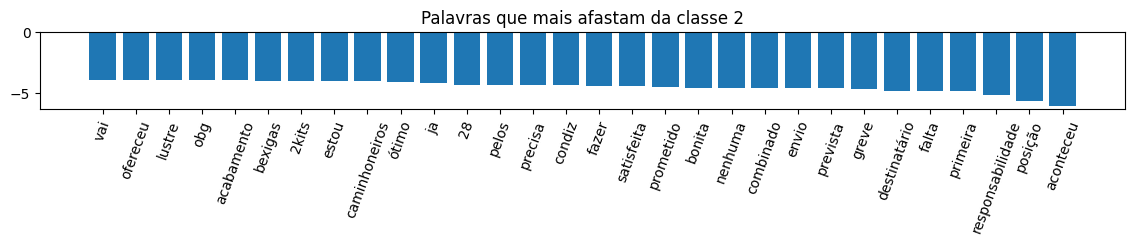

In [53]:
vocabulario = classificador['meu_vetorizador'].vocabulary_
pesos = classificador['meu_classificador'].coef_
print(pesos.shape)

classe_alvo = 1
classe_alvo_str = classificador.classes_[classe_alvo]

palavras_e_pesos = []
for palavra in vocabulario.keys():
    j = vocabulario[palavra]
    coeficiente = pesos[classe_alvo,j]
    palavras_e_pesos.append( (coeficiente, palavra) )

tuplas_ordenadas = sorted(palavras_e_pesos, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 30
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,1))
plt.title('Palavras que mais levam à classe ' + str(classe_alvo_str))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=70)
plt.show()

eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,1))
plt.title('Palavras que mais afastam da classe ' + str(classe_alvo_str))
plt.bar(eixo_x[-n_palavras:], contagens[-n_palavras:])
plt.xticks(eixo_x[-n_palavras:], palavras[-n_palavras:], rotation=70)
plt.show()

Palavras relacionadas a reviws de score 3:

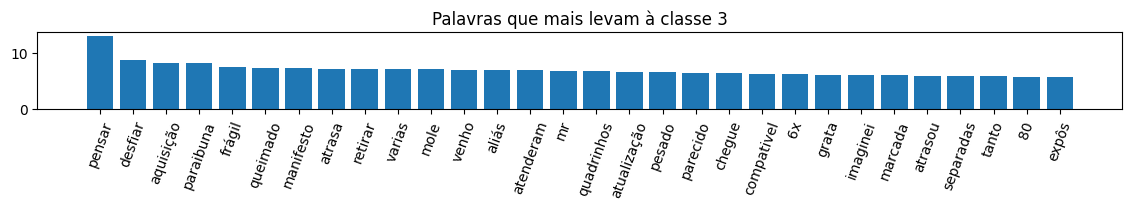

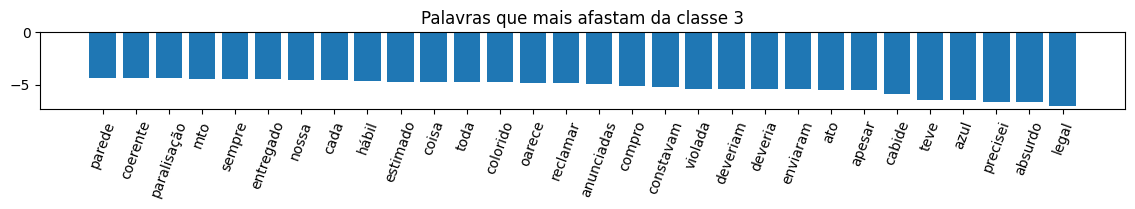

In [51]:
classe_alvo = 2
classe_alvo_str = classificador.classes_[classe_alvo]

palavras_e_pesos = []
for palavra in vocabulario.keys():
    j = vocabulario[palavra]
    coeficiente = pesos[classe_alvo,j]
    palavras_e_pesos.append( (coeficiente, palavra) )

tuplas_ordenadas = sorted(palavras_e_pesos, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 30
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,1))
plt.title('Palavras que mais levam à classe ' + str(classe_alvo_str))
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=70)
plt.show()

eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,1))
plt.title('Palavras que mais afastam da classe ' + str(classe_alvo_str))
plt.bar(eixo_x[-n_palavras:], contagens[-n_palavras:])
plt.xticks(eixo_x[-n_palavras:], palavras[-n_palavras:], rotation=70)
plt.show()